## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: Tues 27 Nov 2018 5pm
* Instructor name: Jeff Herman
* Blog post URL:


In [1]:
import pandas as pd             #For working with data as a DataFrame object
import matplotlib.pyplot as plt #For plotting visualizations
from scipy import stats
import numpy as np
import seaborn as sns           #For plotting advanced visualizations

In [2]:
df_raw = pd.read_csv('kc_house_data.csv') #Import data as a Pandas DataFrame

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format) #To read house prices as $ amounts instead of in scientific notation

## A first look at the raw data

In [51]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21542 entries, 0 to 21596
Data columns (total 10 columns):
price         21542 non-null float64
bedrooms      21542 non-null int64
bathrooms     21542 non-null float64
sqft          21542 non-null int64
waterfront    21542 non-null category
view          21542 non-null category
condition     21542 non-null category
grade         21542 non-null category
yr_built      21542 non-null int64
zipcode       21542 non-null int64
dtypes: category(4), float64(2), int64(4)
memory usage: 1.9+ MB


In [ ]:
df_raw.describe()

**Observations of data summary**

Columns to drop: ID and date (not useful here); lat and long (would be useful, but they're outside the scope of this exploration.)

Categorical columns to transform later: waterfront, view, condition, grade, zip code.

Null values to fill: waterfront, view, yr_renovated.

Price column initially displayed in scientific notation. Suppressed this globally so that prices can be understood as $ amounts.

The max value for bedrooms is preposterous and that row will probably need to be dropped if the rest of the data in the row doesn't describe a 33-bedroom house.

sqft_basement should be in integers to match sqft_above.

**Observations of histograms of each feature**



In [ ]:
df_raw['price'].hist(bins=100, figsize=(8,6))

**price**: Will serve as the target, i.e. 'y', the dependent variable. We'll examine how other features effect the price of a house. A few extreme outliers on the positive side are skewing the data. (Extravagant mansions worth over 3 or 4 million dollars.) Might help to drop them.

**bathrooms**: Looks not too far from a normal distribution, can probably be smoothed out. Some positive skew.

**bedrooms**: Very densely-clustered data, may need to look at another histogram with more bins after dropping outliers.


**floors**: Not categorical but not normally-distributed either. Densely-distributed around the 1-floor and 2-floor values. This makes sense as a house with with fewer than 1 floor wouldn't fit humans. Will need to be log transformed.

**condition**: obviously categorical

**Grade**: Very normally-distributed; categorical. Most houses have a "medium" grade which makes sense. The tails of the distribution will be rundown houses and fancy houses.

**view**: A categorical feature with most houses having a "0" view. Makes sense intuitively that the this data wouldn't be normally distributed: the majority of houses wouldn't have even a "medium"-grade view. They'd have no interesting view at all, just a view of other houses in their neighborhood.

**waterfront**: A categorical feature, "yes" or "no", with the vast majority of houses not being on the waterfront. Makes sense. Might be the case that dropping the extravagant mansion rows will remove most of the "yes" waterfront houses, meaning this column will need to be dropped.

**sqft_above**: Close to a normal distribution wiht some outliers positively skewing the data.

**sqft_living**: Similar shape to sqft_above, outliers positively skewing the data.

**sqft_living15**: Even more normal than sqft_living. Probably contains fewer meaningful values.

**sqft_lot**: A few extreme outliers are positively skewing the data. Might be the same extravagant mansions.

**sqft_lot15**: Similar issue to sqft_lot. A few extreme outliers are positively skewing the data.

**yr_built**: Negative skew towards earlier years. A spurt of new construction in the very recent past. Not sure whether to expect a normal distribution of this feature if we assume that the population of the city increases steadily from decade to decade; the bulk of the housing stock would already exist and wouldn't be replaced, but some new residents would move into new construction neighborhoods.

**yr_renovated**: If only describing renovations after 2015, then it's a categorical column.

## Cleaning the raw data

**Resetting the index**

In [5]:
df_raw = df_raw.reset_index(drop=True) #Keeps dropped rows from throwing errors later

**Dropping irrelevant columns**

In [6]:
df_raw = df_raw.drop(['id', 'date', 'lat', 'long'], axis=1) #Drop the id and date columns

**Dropping the 33-bedroom house**

Let's check if there are any other over-bedroomed houses.

In [7]:
df_raw['bedrooms'].value_counts() #Check for other houses with a lot of bedrooms

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

The 10- and 11-bedroom houses also look suspicious.

In [8]:
beds_10 = df_raw[df_raw['bedrooms'] >= 10]  
beds_10

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
8748,520000.00,11,3.00,3000,4960,2.00,0.00,0.00,3,7,2400,600.0,1918,1999.00,98106,1420,4960
13301,1150000.00,10,5.25,4590,10920,1.00,0.00,2.00,3,9,2500,2090.0,2008,0.00,98004,2730,10400
15147,650000.00,10,2.00,3610,11914,2.00,0.00,0.00,4,7,3010,600.0,1958,0.00,98006,2040,11914
15856,640000.00,33,1.75,1620,6000,1.00,0.00,0.00,5,7,1040,580.0,1947,0.00,98103,1330,4700
19239,660000.00,10,3.00,2920,3745,2.00,0.00,0.00,4,7,1860,1060.0,1913,0.00,98105,1810,3745


The only house whose specs look plausible is row 13301. (5 bathrooms, price over 1 mil.) Going to drop the others.

In [9]:
df_raw = df_raw.drop([8748, 15147, 15856, 19239]) # Drop the rows with 10-or-more-bed houses

**Dropping the extravagant mansions**

Positive skew in the histogram of the price column suggests that a few extremely-high-value houses could be dropped.

In [10]:
df_raw['price'].quantile(.99) #Return 99th percentile

1970000.0

99% percent of the houses in the dataset have a price under 2 million.

In [ ]:
over2mil = df_raw[df_raw['price'] > 2000000]
over3mil = df_raw[df_raw['price'] > 3000000]
over4mil = df_raw[df_raw['price'] > 4000000]

print('House prices over 2 mil: ', over2mil.shape[0])
print('House prices over 3 mil: ', over3mil.shape[0])
print('House prices over 4 mil: ', over4mil.shape[0])

Let's drop the most extreme outliers to reduce the positive skew of the price feature.

In [11]:
df_raw = df_raw[df_raw['price'] < 3000000] #Drop rows with price over 3 mil

**Filling in null values for waterfront**

How many null values?

In [12]:
df_raw['waterfront'].isna().sum() #Every null value is returned as False; add up the Falses for total of nulls

2375

It's safe to assume these 2376 houses do not front the water. Let's fill them with 0. Later they'll be converted to a categorical value.

In [13]:
df_raw['waterfront'] = df_raw['waterfront'].fillna(0) #Fill null values with 0, i.e. "Is waterfront = False"

**Filling in null values for view**

How many null values are there, and which other value is the most reasonable to fill them with?

In [14]:
print(df_raw['view'].value_counts()) #Returns the sum of the observations of each value in the column
print('\n')
print('Total nulls: ', df_raw['view'].isna().sum())

0.00    19403
2.00      953
3.00      506
1.00      328
4.00      290
Name: view, dtype: int64


Total nulls:  62


Most houses have a "0" view. That's a pity. We can assume the 62 nulls also have a "0" view.

In [15]:
df_raw['view'] = df_raw['view'].fillna(0)

**Filling in null values for yr_renovated**

How many rows have a yr_renovated value that isn't 0 or null?

In [16]:
yr_rn_total = df_raw.shape[0] #Total number of rows in yr_renovated
yr_rn_zeros = df_raw[df_raw['yr_renovated'] == 0.00].shape[0] #Number of 0 values in yr_renovated
yr_rn_nulls = df_raw['yr_renovated'].isna().sum() #Number of nulls in yr_renovated

print('Rows in yr_renovated: ', yr_rn_total)
print('Zero values: ', yr_rn_zeros)
print('Null values: ', yr_rn_nulls)
print('Non-zero, non-null values: ', (yr_rn_total - yr_rn_zeros - yr_rn_nulls))

Rows in yr_renovated:  21542
Zero values:  16972
Null values:  3835
Non-zero, non-null values:  735


Not enough values for the column to be useful. Let's drop it.

In [17]:
df_raw = df_raw.drop(['yr_renovated'], axis=1) #Drop the yr_renovated column

**Converting sqft_basement to integers**

In [18]:
df_raw['sqft_basement'].head(6)

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
Name: sqft_basement, dtype: object

In [19]:
type(df_raw['sqft_basement'][1]) #Looks like the float 400.0 but is actually the str'400.0'

str

This column is riddled with '?'s and values that look numerical but are actually strings. Let's replace '?' with 0, and convert the fake number strings into floats, and then into integers.

In [20]:
df_raw['sqft_basement'] = df_raw['sqft_basement'].replace('?', 0)
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('float') #Must convert strings to floats first
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('int') #Then convert the floats to integers

## A second look

In [ ]:
df_raw['price'].hist(bins=100)

In [ ]:
columns_for_hist = ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'price', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15']

plt.figure(figsize=(10,10))
plt.scatter(df_raw['bedrooms'], df_raw['price'])
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df_raw['sqft_lot'], df_raw['price'], label='sqft_lot')
plt.scatter(df_raw['sqft_lot15'], df_raw['price'], label='sqft_lot15')
plt.title('Measures of lot square footage')
plt.legend()

### Checking for multicollinearity

Let's use a heatmap to check if any features are collinear with any others. Collinearity could reduce the accuracy of our model later on.

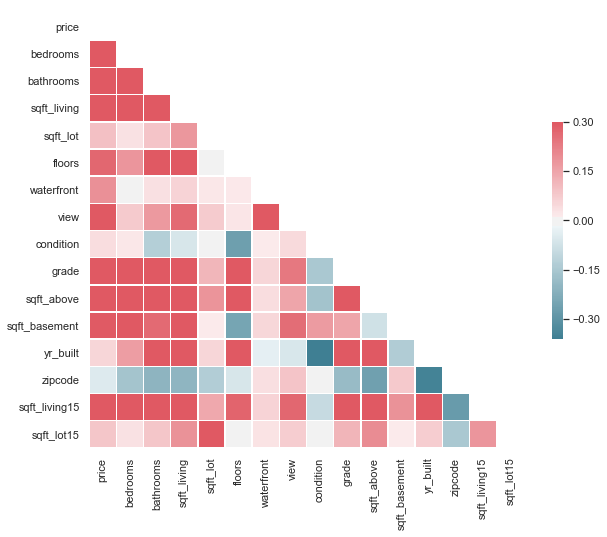

In [23]:
sns.set(style="white")
corr = df_raw.corr() # Create a covariance matrix
mask = np.zeros_like(corr, dtype=np.bool) #a mask the size of the matrix
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 8)) # Set up the matplotlib figure
cmap = sns.diverging_palette(220, 10, as_cmap=True) #custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, #Draw the heatmap
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Yikes. There is a lot of collinearity across columns. But we probably don't need 6 different measures of square footage. Let's pick 1 or 2.

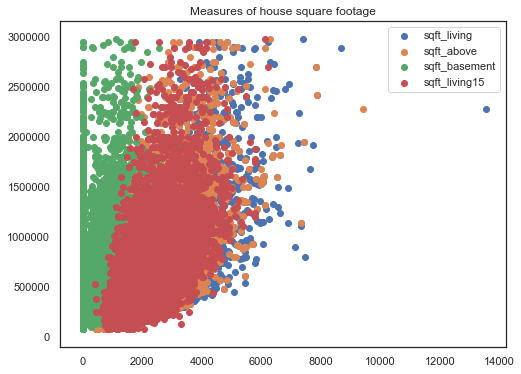

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_living'], df_raw['price'], label='sqft_living')
plt.scatter(df_raw['sqft_above'], df_raw['price'], label='sqft_above')
plt.scatter(df_raw['sqft_basement'], df_raw['price'], label='sqft_basement')
plt.scatter(df_raw['sqft_living15'], df_raw['price'], label='sqft_living15')
plt.title('Price by measures of house square footage')
plt.legend()

A lot of overlap among all 4. Let's keep sqft_living and drop the rest.

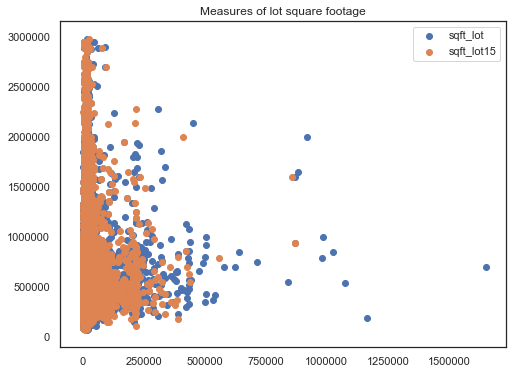

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_lot'], df_raw['price'], label='sqft_lot')
plt.scatter(df_raw['sqft_lot15'], df_raw['price'], label='sqft_lot15')
plt.title('Price by measures of lot square footage')
plt.legend()

Neither of these looks very helpful. Not only do they overlap each other quite closely, but the upward thrust suggests that smaller lots are priced across the full range of price values. In other words, you can probably maximize the value of your house even if your lot is small.

In [26]:
df_raw = df_raw.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 
                      'sqft_lot', 'sqft_lot15'], axis=1) #Drop multicollinear columns
df_raw = df_raw.rename(index=str, columns={'sqft_living': 'sqft'})

## Questions

1. How strong is the relationship between price on the one hand and view and waterfront on the other? These features of a house are outside the control of the homeowner. If the relationship is weak, we may be able to encourage homeowners that they can maximize their house's value with features under their control.

2. Should you improve the condition of your house before you try to sell it, or is it possible to get a high price on a ramshackle house on the merits of its other features, e.g. its location?

3. Do certain zip codes have more high-value houses than others? If so, a good way to increase the value of one's home may be to seek out improvements in the larger neighborhood.

In [ ]:
plt.plot(df_raw['zip'])

In [41]:
#sns.pairplot(df_raw, x_vars=[df_raw['view'], df_raw['waterfront']], y_vars=df_raw['price'], kind='reg', height=(10))

## Feature scaling of continuous variables

In [67]:
df_normed = df_raw.copy() # A deep copy of the raw data to normalize

**Box-Cox transformation (TEST)**

In [ ]:
#BoxCox experiment

#plt.hist(df_raw['sqft_living'], bins=50)

In [ ]:
#transform = np.asarray(df_raw[['sqft_living']].values)

In [ ]:
#dft = stats.boxcox(transform)[0]

In [ ]:
#plt.hist(dft, bins=50)
#plt.show()

**Log-transforming of continuous variables**

In [71]:
price_normed = np.log(df_normed['price'])
sqft_normed = np.log(df_normed['sqft']) 
yr_built_normed = np.log(df_normed['yr_built'])

**Scaling continuous variables**

In [115]:
#Use min-max scaling to reduce effect of outliers
price_normed = (price_normed - min(price_normed)) / (max(price_normed) - min(price_normed))

#Standardize to take z-scores
sqft_normed = (sqft_normed - sqft_normed.mean()) / sqft_normed.std()
yr_built_normed = (yr_built_normed - yr_built_normed.mean()) / yr_built_normed.std()

In [84]:
df_normed['price'] = price_normed
df_normed['sqft'] = sqft_normed
df_normed['yr_built'] = yr_built_normed

## Converting categorical variables

In [85]:
df_cat = df_normed.copy() #Normalized data, ready for categorizing

In [86]:
#Convert data to dtype 'category'
df_cat['waterfront'] = df_cat['waterfront'].astype('bool').astype('category')
df_cat['view'] = df_cat['view'].astype('int').astype('category')
df_cat['condition'] = df_cat['condition'].astype('int').astype('category')
df_cat['grade'] = df_cat['grade'].astype('int').astype('category')
df_cat['zipcode'] = df_cat['zipcode'].astype('category')

In [87]:
#Create a new set of columns for each category
water_dummies = pd.get_dummies(df_cat['waterfront'], prefix='water')
view_dummies = pd.get_dummies(df_cat['view'], prefix='view')
condit_dummies = pd.get_dummies(df_cat['condition'], prefix='condit')
grade_dummies = pd.get_dummies(df_cat['grade'], prefix='grade')
zip_dummies = pd.get_dummies(df_cat['zipcode'], prefix='zip')

In [88]:
#Drop original columns
df_cat = df_cat.drop(['waterfront', 'view', 'condition', 'grade', 'zipcode'], axis=1)
#Add the new columns
df_cat = pd.concat([df_cat, water_dummies, view_dummies, condit_dummies, grade_dummies, zip_dummies], axis=1)
print(f"df_cat now has {df.shape[1]} columns")

df now has 98 columns


Now let's drop the last column of each category. (Values not contained in any other column in the set of dummies will by default by contained in the last column, so we can assume they are there and drop it.)

In [104]:
df_cat = df_cat.drop(['water_True', 'view_4', 
                      'condit_5', 'grade_13', 'zip_98199'], axis=1)

## Modeling

In [89]:
df = df_cat.copy() #Final version of data, ready for modeling

What about the number of bedrooms, bathrooms, and floors? Could sqft serve as a proxy for these?

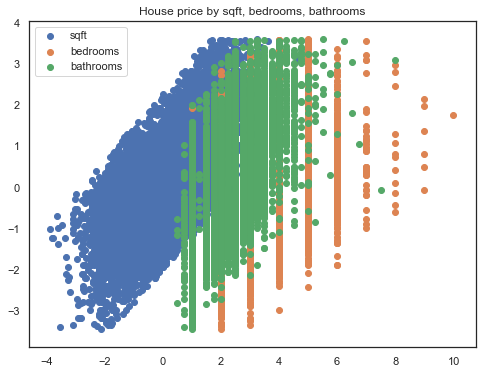

In [98]:
plt.figure(figsize=(8,6))
plt.scatter(df['sqft'], df['price'], label='sqft')
plt.scatter(df['bedrooms'], df['price'], label='bedrooms')
plt.scatter(df['bathrooms'], df['price'], label='bathrooms')
plt.scatter(df['floors'], df['price'], label='floors')
plt.title('House price by sqft, bedrooms, bathrooms, floors')
plt.legend()
plt.show()

Strong collinearity among sqft, bedrooms, and bathrooms. It looks like sqft will have the clearest linear relationship with price, so let's use it in comparisons with the other features. It can be taken as a good proxy for the overall area of a house's rooms and floors.

In [ ]:
df = df.drop(['bedrooms', 'bathrooms', 'floors', axis=1])

**Iterative regression**


**ordinary least squares**
use smf.ols
build a formula to put into the function



**recursive feature elimination** 
    Import RFE from sklearn
    make a for loop to run linreg on the data with first 1 feature, then several, then several more, &c. Set up a range with numpy from 1 to the total number of features, going up by 10 or so
    will start to overfit as more features are added
    Compare r square and r square adjusted
    Values will get higher as model gets more accurate (approaching 1 from 0)
    
**train test split**
    Import train test split from sklearn
    Function takes 4 variables
    Perform linreg on the train set and the test set, then compare:
    Calculate MSEs for both train results and test results
    Value will get smaller as model gets more accurate (error gets closer to 0)


**k fold cross validation**
    Pick best features to use by calling RFE
    Call cross_val_score with linreg, X, and y, and choose  a number of folds.
    Returns an array of negative MSEs
    If there are a lot of dummy/categorical variable columns, some MSEs in the resulting array will have weird results. If so, use fewer predictors.
holdout validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

docstrings for original functions
map with longitudes/latitudes?
what is "grade" -- look at king county

good summary of linear regression in python at https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606

In [ ]:
Saving this in case it comes up again:
    df_raw.loc[0, 'sqft_basement'] = 0 #Correct way to insert a value into a df without chain indexing